In [21]:
import sympy as sp

# Define symbolic joint variables
q1, q2, q3, q4 = sp.symbols('q1 q2 q3 q4')
dq1, dq2, dq3, dq4 = sp.symbols('dq1 dq2 dq3 dq4')
ddq1, ddq2, ddq3, ddq4 = sp.symbols('ddq1 ddq2 ddq3 ddq4')

q = sp.Matrix([q1, q2, q3, q4])
dq = sp.Matrix([dq1, dq2, dq3, dq4])
ddq = sp.Matrix([ddq1, ddq2, ddq3, ddq4])

# Constants (link lengths, masses, inertia)
a1, a2, a3, a4 = 50, 93, 93, 50  # in mm
a1, a2, a3, a4 = [dim / 1000 for dim in (a1, a2, a3, a4)]  # convert to meters

m1, m2, m3, m4 = 0.06, 0.08, 0.08, 0.04  # masses in kg
I0 = 7.625e-6  # From your estimation

# Inertia matrices for each link in their local frames
D_bar_1 = sp.diag(I0, 0.4*I0, 0.9*I0)
D_bar_2 = D_bar_3 = sp.diag(0.45*I0, 1.4*I0, 1.2*I0)
D_bar_4 = sp.diag(0.5*I0, 0.5*I0, 0.5*I0)


In [22]:
def DH_transform(theta, d, a, alpha):
    return sp.Matrix([
        [sp.cos(theta), -sp.sin(theta)*sp.cos(alpha),  sp.sin(theta)*sp.sin(alpha), a*sp.cos(theta)],
        [sp.sin(theta),  sp.cos(theta)*sp.cos(alpha), -sp.cos(theta)*sp.sin(alpha), a*sp.sin(theta)],
        [0,              sp.sin(alpha),               sp.cos(alpha),               d],
        [0,              0,                           0,                           1]
    ])


In [23]:
# Define alpha values
alpha0, alpha1, alpha2, alpha3 = sp.pi/2, 0, 0, 0

# Transformation matrices
T01 = DH_transform(q1, a1, 0, alpha0)
T12 = DH_transform(q2, 0, a2, alpha1)
T23 = DH_transform(q3, 0, a3, alpha2)
T34 = DH_transform(q4, 0, a4, alpha3)

# Compute cumulative transformations
T02 = T01 * T12
T03 = T02 * T23
T04 = T03 * T34


In [24]:
R01 = T01[:3, :3]
R02 = T02[:3, :3]
R03 = T03[:3, :3]
R04 = T04[:3, :3]


In [25]:
# Position vectors of the end of each link in base frame
p0 = sp.Matrix([0, 0, 0])
p1 = T01[:3, 3]
p2 = T02[:3, 3]
p3 = T03[:3, 3]
p4 = T04[:3, 3]

# Assuming centers of mass are at a fraction along the link
# For simplicity, let's assume they are at the middle of each link
# Adjust according to your robot's actual COM positions

# COM positions
p_c1 = p0 + 0.5 * (p1 - p0)
p_c2 = p1 + 0.5 * (p2 - p1)
p_c3 = p2 + 0.5 * (p3 - p2)
p_c4 = p3 + 0.5 * (p4 - p3)


In [26]:
# z axes
z0 = sp.Matrix([0, 0, 1])  # Base frame z-axis
z1 = R01[:, 2]
z2 = R02[:, 2]
z3 = R03[:, 2]

# Origins
o0 = sp.Matrix([0, 0, 0])
o1 = T01[:3, 3]
o2 = T02[:3, 3]
o3 = T03[:3, 3]


In [27]:
# For Link 1
Jv1 = sp.Matrix.hstack(
    z0.cross(p_c1 - o0),
    sp.zeros(3, 3)
)
Jw1 = sp.Matrix.hstack(
    z0,
    sp.zeros(3, 3)
)

# For Link 2
Jv2 = sp.Matrix.hstack(
    z0.cross(p_c2 - o0),
    z1.cross(p_c2 - o1),
    sp.zeros(3, 2)
)
Jw2 = sp.Matrix.hstack(
    z0,
    z1,
    sp.zeros(3, 2)
)

# For Link 3
Jv3 = sp.Matrix.hstack(
    z0.cross(p_c3 - o0),
    z1.cross(p_c3 - o1),
    z2.cross(p_c3 - o2),
    sp.zeros(3, 1)
)
Jw3 = sp.Matrix.hstack(
    z0,
    z1,
    z2,
    sp.zeros(3, 1)
)

# For Link 4
Jv4 = sp.Matrix.hstack(
    z0.cross(p_c4 - o0),
    z1.cross(p_c4 - o1),
    z2.cross(p_c4 - o2),
    z3.cross(p_c4 - o3)
)
Jw4 = sp.Matrix.hstack(
    z0,
    z1,
    z2,
    z3
)


In [28]:
# Transform inertia matrices to base frame
I1 = R01 * D_bar_1 * R01.T
I2 = R02 * D_bar_2 * R02.T
I3 = R03 * D_bar_3 * R03.T
I4 = R04 * D_bar_4 * R04.T

# Mass matrix contributions from each link
D1 = Jv1.T * m1 * Jv1 + Jw1.T * I1 * Jw1
D2 = Jv2.T * m2 * Jv2 + Jw2.T * I2 * Jw2
D3 = Jv3.T * m3 * Jv3 + Jw3.T * I3 * Jw3
D4 = Jv4.T * m4 * Jv4 + Jw4.T * I4 * Jw4

# Total mass matrix
D = D1 + D2 + D3 + D4


In [29]:
D = sp.simplify(D)


In [30]:
n = 4  # Number of joints
C = sp.zeros(n, n)

for i in range(n):
    for j in range(n):
        C_ij = 0
        for k in range(n):
            C_ijk = 0.5 * (
                D[i, j].diff(q[k]) +
                D[i, k].diff(q[j]) -
                D[j, k].diff(q[i])
            )
            C_ij += C_ijk * dq[k]
        C[i, j] = C_ij


In [31]:
C = sp.simplify(C)


In [38]:
C.shape

(4, 4)

In [32]:
g_vector = sp.Matrix([0, 0, -9.81])  # m/s^2


In [33]:
U = m1 * g_vector.dot(p_c1) + m2 * g_vector.dot(p_c2) + m3 * g_vector.dot(p_c3) + m4 * g_vector.dot(p_c4)


In [34]:
g = sp.Matrix([sp.diff(U, q_i) for q_i in [q1, q2, q3, q4]])
g = sp.simplify(g)


In [35]:
from sympy.utilities.lambdify import lambdify

# Create numerical functions
D_func = lambdify((q1, q2, q3, q4), D, modules='numpy')
C_func = lambdify((q1, q2, q3, q4, dq1, dq2, dq3, dq4), C, modules='numpy')
g_func = lambdify((q1, q2, q3, q4), g, modules='numpy')


In [41]:
from math import cos, sin, atan2, acos, sqrt, pi
def inv_kinematics(x,y,z,phi):
    """ """
    a1,a2,a3,a4 = 50, 93, 93, 50 # mm

    theta1 = atan2(y, x)

    r = sqrt(x*x + y*y)
    r2 = a4 * cos(phi)
    r1 = r - r2

    d1 = a1
    d3 = a4*sin(phi)
    d2 = z - d1 - d3

    C23 = sqrt(r1*r1 + d2*d2)

    # Elbow down
    # theta3 = -acos((a2*a2 + a3*a3 - C23*C23) / (2*a2*a3)) + pi

    # Elbow up - not minus in front of sqrt()
    D = (C23*C23 - a2*a2 - a3*a3) / (-2*a2*a3)
    theta3 = -(atan2(-sqrt(1 - D*D), D) - pi)

    theta2 = atan2(d2, r1) - atan2(a3*sin(theta3), a2+a3*cos(theta3))
    theta4 = phi - theta2 - theta3
    
    return theta1, theta2, theta3, theta4

In [51]:
import numpy as np
T=8
num_samples = 10000
# Time vector
time = np.linspace(0, T, num_samples)
dt = T / (num_samples - 1)

# Compute q, dq, ddq at each time step (use your inverse kinematics and trajectory functions)
# Define the circular trajectory
radius = 0.032  # meters
center_x = 0.015  # meters
center_y = 0.0  # meters
center_z = 0.012  # meters

# Initialize arrays for joint variables
q_array = np.zeros((num_samples, 4))
dq_array = np.zeros((num_samples, 4))
ddq_array = np.zeros((num_samples, 4))

# Loop over each time step to compute q, dq, ddq
for i in range(num_samples):
    t = time[i]
    
    # Compute end-effector position (example: circular motion)
    x = center_x + radius * np.cos(2 * np.pi * t / T)
    y = center_y + radius * np.sin(2 * np.pi * t / T)
    z = center_z  # Constant height
    phi = 0  # Constant orientation (adjust as needed)
    
    # Inverse kinematics to get joint angles
    q = inv_kinematics(x, y, z, phi)
    q_array[i, :] = q
    
    # Numerically compute velocities and accelerations
    if i > 0:
        dq_array[i, :] = (q_array[i, :] - q_array[i - 1, :]) / dt
    if i > 1:
        ddq_array[i, :] = (dq_array[i, :] - dq_array[i - 1, :]) / dt

# Initialize torque array
tau_array = np.zeros((num_samples, 4))

for i in range(num_samples):
    q_vals = q_array[i, :]
    dq_vals = dq_array[i, :]
    ddq_vals = ddq_array[i, :]
    
    # Handle initial conditions
    if i == 0:
        dq_vals = np.zeros(4)
        ddq_vals = np.zeros(4)
    elif i == 1:
        ddq_vals = np.zeros(4)
    
    # Ensure vectors are 1D arrays
    q_vals = np.array(q_vals, dtype=float).flatten()
    dq_vals = np.array(dq_vals, dtype=float).flatten()
    ddq_vals = np.array(ddq_vals, dtype=float).flatten()
    
    # Compute D and g numerically
    D_num = np.array(D_func(*q_vals), dtype=float)
    g_num = np.array(g_func(*q_vals), dtype=float).flatten()
    
    # Optionally compute C_num if possible
    try:
        C_num = np.array(C_func(*q_vals, *dq_vals), dtype=float)
        if C_num.ndim == 3:
            C_num = np.einsum('ijk,k->ij', C_num, dq_vals)
        C_dq = C_num @ dq_vals
    except Exception as e:
        print(f"Could not compute C_num: {e}")
        C_dq = np.zeros(4)
    
    # Compute torque
    tau = D_num @ ddq_vals + C_dq + g_num
    tau = tau.flatten()
    
    # Store tau
    tau_array[i, :] = tau


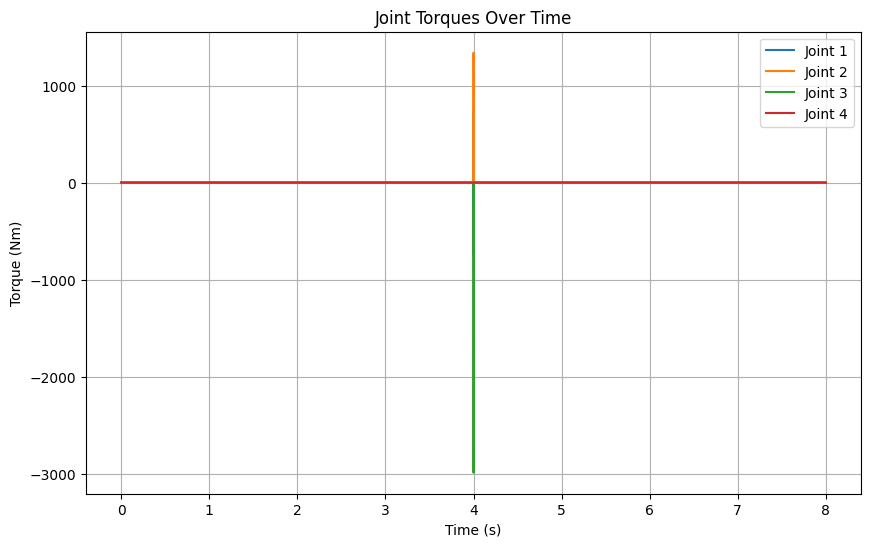

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(time, tau_array[:, i], label=f'Joint {i+1}')

plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Joint Torques Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [54]:
import numpy as np
from math import atan2, sqrt, cos, sin, acos, pi

def inv_kinematics_all_solutions(x, y, z, phi):
    """
    Computes all possible sets of joint angles [theta1, theta2, theta3, theta4]
    for the given end-effector position (x, y, z) and orientation phi.
    """
    # Robot dimensions in mm
    a1, a2, a3, a4 = 50, 93, 93, 50  # mm

    # Convert to meters if necessary
    a1 /= 1000.0
    a2 /= 1000.0
    a3 /= 1000.0
    a4 /= 1000.0

    # Position adjustments
    x = x - a4 * cos(phi)
    y = y - a4 * sin(phi)
    z = z

    # Compute theta1
    theta1 = atan2(y, x)

    # Compute wrist position
    r = sqrt(x**2 + y**2)
    s = z - a1

    # Compute D for cosine law
    D = (r**2 + s**2 - a2**2 - a3**2) / (2 * a2 * a3)

    # Check if the position is reachable
    if abs(D) > 1:
        # Position is unreachable
        return []

    # Possible values for theta3
    theta3_options = []
    theta3_positive = atan2(sqrt(1 - D**2), D)
    theta3_negative = atan2(-sqrt(1 - D**2), D)
    theta3_options.extend([theta3_positive, theta3_negative])

    # Compute corresponding theta2 and theta4 for each theta3
    solutions = []
    for theta3 in theta3_options:
        # Compute theta2
        k1 = a2 + a3 * cos(theta3)
        k2 = a3 * sin(theta3)
        theta2 = atan2(s, r) - atan2(k2, k1)

        # Compute theta4
        theta4 = phi - theta2 - theta3

        # Normalize angles to be within [-pi, pi]
        theta1 = atan2(sin(theta1), cos(theta1))
        theta2 = atan2(sin(theta2), cos(theta2))
        theta3 = atan2(sin(theta3), cos(theta3))
        theta4 = atan2(sin(theta4), cos(theta4))

        # Append the solution
        solutions.append((theta1, theta2, theta3, theta4))

    return solutions


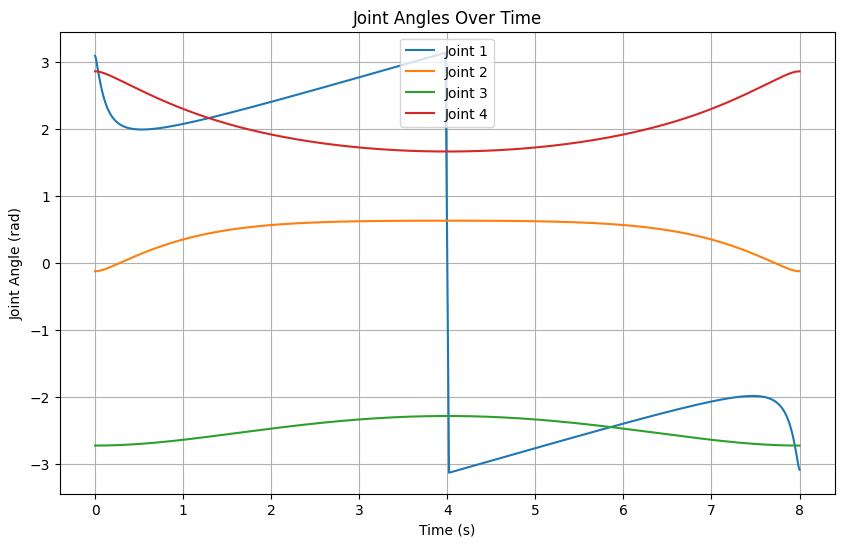

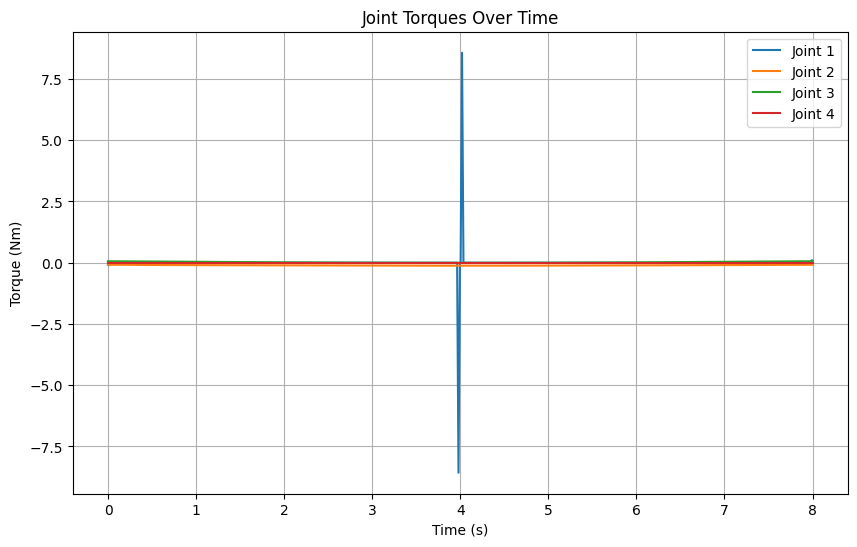

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

T = 8
num_samples = 1000  # Increased number of samples
dt = T / (num_samples - 1)
time = np.linspace(0, T, num_samples)

# Trajectory parameters
radius = 0.032  # meters
center_x = 0.015  # meters
center_y = 0.0  # meters
center_z = 0.012  # meters

# Initialize arrays
q_array = np.zeros((num_samples, 4))
dq_array = np.zeros((num_samples, 4))
ddq_array = np.zeros((num_samples, 4))

# Previous joint angles
q_prev = None

for i in range(num_samples):
    t = time[i]
    
    # Compute end-effector position
    x = center_x + radius * np.cos(2 * np.pi * t / T)
    y = center_y + radius * np.sin(2 * np.pi * t / T)
    z = center_z
    phi = 0  # Adjust as needed

    # Inverse kinematics to get all possible joint angles
    q_solutions = inv_kinematics_all_solutions(x, y, z, phi)
    
    if not q_solutions:
        print(f"Position unreachable at time {t:.2f}s")
        continue  # Skip this time step if no solutions

    if q_prev is not None:
        # Select the solution closest to q_prev
        q = min(q_solutions, key=lambda q_sol: np.linalg.norm(np.array(q_sol) - q_prev))
    else:
        # For the first point, select any solution
        q = q_solutions[1]

    q_array[i, :] = q
    q_prev = np.array(q)

# Smooth the joint angles
window_size = 5
for joint in range(4):
    q_array[:, joint] = uniform_filter1d(q_array[:, joint], size=window_size)

# Compute velocities and accelerations using central differences
dq_array[1:-1, :] = (q_array[2:, :] - q_array[:-2, :]) / (2 * dt)
dq_array[0, :] = (q_array[1, :] - q_array[0, :]) / dt
dq_array[-1, :] = (q_array[-1, :] - q_array[-2, :]) / dt

ddq_array[1:-1, :] = (dq_array[2:, :] - dq_array[:-2, :]) / (2 * dt)
ddq_array[0, :] = (dq_array[1, :] - dq_array[0, :]) / dt
ddq_array[-1, :] = (dq_array[-1, :] - dq_array[-2, :]) / dt

# Plot joint angles to verify continuity
plt.figure(figsize=(10, 6))
for joint in range(4):
    plt.plot(time, q_array[:, joint], label=f'Joint {joint + 1}')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (rad)')
plt.title('Joint Angles Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Initialize torque array
tau_array = np.zeros((num_samples, 4))

for i in range(num_samples):
    q_vals = q_array[i, :]
    dq_vals = dq_array[i, :]
    ddq_vals = ddq_array[i, :]

    # Ensure vectors are 1D arrays
    q_vals = np.array(q_vals, dtype=float).flatten()
    dq_vals = np.array(dq_vals, dtype=float).flatten()
    ddq_vals = np.array(ddq_vals, dtype=float).flatten()

    # Compute D and g numerically
    D_num = np.array(D_func(*q_vals), dtype=float)
    g_num = np.array(g_func(*q_vals), dtype=float).flatten()

    # Compute torque (simplified without Coriolis for this example)
    tau = D_num @ ddq_vals + g_num
    tau_array[i, :] = tau

# Plot joint torques
plt.figure(figsize=(10, 6))
for joint in range(4):
    plt.plot(time, tau_array[:, joint], label=f'Joint {joint + 1}')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Joint Torques Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [57]:
# Test position
x_test = 0.15  # meters
y_test = 0.0
z_test = 0.12  # meters
phi_test = 0  # radians

solutions = inv_kinematics_all_solutions(x_test, y_test, z_test, phi_test)
print("Inverse Kinematics Solutions:")
for idx, sol in enumerate(solutions):
    theta1, theta2, theta3, theta4 = sol
    print(f"Solution {idx + 1}:")
    print(f"  theta1 = {theta1 * 180 / np.pi:.2f} degrees")
    print(f"  theta2 = {theta2 * 180 / np.pi:.2f} degrees")
    print(f"  theta3 = {theta3 * 180 / np.pi:.2f} degrees")
    print(f"  theta4 = {theta4 * 180 / np.pi:.2f} degrees")


Inverse Kinematics Solutions:
Solution 1:
  theta1 = 0.00 degrees
  theta2 = -13.99 degrees
  theta3 = 97.97 degrees
  theta4 = -83.98 degrees
Solution 2:
  theta1 = 0.00 degrees
  theta2 = 83.98 degrees
  theta3 = -97.97 degrees
  theta4 = 13.99 degrees


## Plot robot arm

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def forward_kinematics1(t1, t2=None, t3=None, t4=None):
    return np.array([
        [np.cos(t1), 0, np.sin(t1), 0],
        [np.sin(t1), 0, -np.cos(t1), 0],
        [0, 1, 0, 50/1000],
        [0, 0, 0, 1]
    ])

def forward_kinematics2(t1, t2, t3=None, t4=None):
    return np.array([
        [
            (np.cos(t1 - t2) + np.cos(t1 + t2)) / 2,
            (-np.sin(t1 + t2) + np.sin(t1 - t2)) / 2,
            np.sin(t1),
            (93/1000 * np.cos(t1 - t2) + 93/1000 * np.cos(t1 + t2)) / 2
        ],
        [
            (np.sin(t1 + t2) + np.sin(t1 - t2)) / 2,
            (-np.cos(t1 - t2) + np.cos(t1 + t2)) / 2,
            -np.cos(t1),
            (93/1000 * np.sin(t1 + t2) + 93/1000 * np.sin(t1 - t2)) / 2
        ],
        [
            np.sin(t2),
            np.cos(t2),
            0,
            50/1000 + 93/1000 * np.sin(t2)
        ],
        [0, 0, 0, 1]
    ])

def forward_kinematics3(t1, t2, t3, t4=None):
    return np.array([
        [
            (np.cos(-t3 + t1 - t2) + np.cos(t3 + t1 + t2)) / 2,
            (np.sin(-t3 + t1 - t2) - np.sin(t3 + t1 + t2)) / 2,
            np.sin(t1),
            (93/1000 * np.cos(-t3 + t1 - t2) + 93/1000 * np.cos(t3 + t1 + t2)) / 2 +
            (93/1000 * np.cos(t1 - t2) + 93/1000 * np.cos(t1 + t2)) / 2
        ],
        [
            (np.sin(t3 + t1 + t2) + np.sin(-t3 + t1 - t2)) / 2,
            (np.cos(t3 + t1 + t2) - np.cos(-t3 + t1 - t2)) / 2,
            -np.cos(t1),
            (93/1000 * np.sin(t3 + t1 + t2) + 93/1000 * np.sin(-t3 + t1 - t2)) / 2 +
            (93/1000 * np.sin(t1 + t2) + 93/1000 * np.sin(t1 - t2)) / 2
        ],
        [
            np.sin(t2 + t3),
            np.cos(t2 + t3),
            0,
            50/1000 + 93/1000 * np.sin(t2 + t3) + 93/1000 * np.sin(t2)
        ],
        [0, 0, 0, 1]
    ])


def forward_kinematics4(t1, t2, t3, t4):
    """ straight out of chatgpt """
    # Row 1
    r11 = (cos(t4 + t3 + t1 + t2) + cos(-t4 - t3 + t1 - t2)) / 2
    r12 = (-sin(t4 + t3 + t1 + t2) + sin(-t4 - t3 + t1 - t2)) / 2
    r13 = sin(t1)
    r14 = (25/1000 * cos(t4 + t3 + t1 + t2) + 25/1000 * cos(-t4 - t3 + t1 - t2) +
           (93/1000 * cos(-t3 + t1 - t2) + 93/1000 * cos(t3 + t1 + t2) + 
           93/1000 * cos(t1 - t2) + 93/1000 * cos(t1 + t2)) / 2)

    # Row 2
    r21 = (sin(-t4 - t3 + t1 - t2) + sin(t4 + t3 + t1 + t2)) / 2
    r22 = (-cos(-t4 - t3 + t1 - t2) + cos(t4 + t3 + t1 + t2)) / 2
    r23 = -cos(t1)
    r24 = (25/1000 * sin(-t4 - t3 + t1 - t2) + 25/1000 * sin(t4 + t3 + t1 + t2) +
           (93/1000 * sin(t3 + t1 + t2) + 93/1000 * sin(-t3 + t1 - t2) + 
           93/1000 * sin(t1 + t2) + 93/1000 * sin(t1 - t2)) / 2)

    # Row 3
    r31 = sin(t2 + t3 + t4)
    r32 = cos(t2 + t3 + t4)
    r33 = 0
    r34 = 50/1000 + 50/1000 * sin(t2 + t3 + t4) + 93/1000 * sin(t2 + t3) + 93/1000 * sin(t2)

    # Row 4 (last row in homogeneous transformation matrices)
    r41 = 0
    r42 = 0
    r43 = 0
    r44 = 1

    # Assembling the 4x4 matrix as a nested list
    transformation_matrix = [
        [r11, r12, r13, r14],
        [r21, r22, r23, r24],
        [r31, r32, r33, r34],
        [r41, r42, r43, r44]
    ]

    return np.array(transformation_matrix)


In [74]:
def plot_robot_arm(q, ax):
    """
    Plots the robot arm configuration given joint angles q = [theta1, theta2, theta3, theta4].
    """
    # Compute transformation matrices
    T01 = forward_kinematics1(q[0])
    T02 = forward_kinematics2(q[0], q[1])
    T03 = forward_kinematics3(q[0], q[1], q[2])
    T04 = forward_kinematics4(q[0], q[1], q[2], q[3])

    # Extract joint positions
    p0 = np.array([0, 0, 0])  # Base position
    p1 = T01[:3, 3]
    p2 = T02[:3, 3]
    p3 = T03[:3, 3]
    p4 = T04[:3, 3]  # End-effector position

    # Stack positions for plotting
    positions = np.vstack((p0, p1, p2, p3, p4))

    # Plot links
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], '-o', linewidth=2)

    # Set plot limits and labels
    ax.set_xlim(-0.2, 0.2)
    ax.set_ylim(-0.2, 0.2)
    ax.set_zlim(0, 0.3)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('Robot Arm Configuration')


In [75]:
# Initialize array to store end-effector positions
ee_positions = np.zeros((num_samples, 3))

for i in range(num_samples):
    q = q_array[i, :]

    # Compute forward kinematics to get end-effector position
    T04 = forward_kinematics4(q[0], q[1], q[2], q[3])
    p4 = T04[:3, 3]

    ee_positions[i, :] = p4

# Intended trajectory
intended_positions = np.zeros((num_samples, 3))

for i in range(num_samples):
    t = time[i]
    x = center_x + radius * np.cos(2 * np.pi * t / T)
    y = center_y + radius * np.sin(2 * np.pi * t / T)
    z = center_z
    intended_positions[i, :] = [x, y, z]


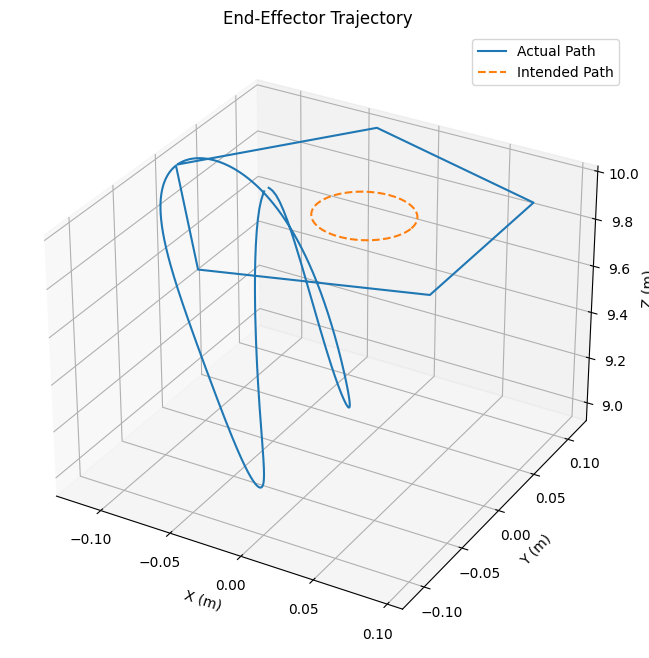

In [76]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the end-effector path
ax.plot(ee_positions[:, 0], ee_positions[:, 1], ee_positions[:, 2], label='Actual Path')

# Plot the intended path
ax.plot(intended_positions[:, 0], intended_positions[:, 1], intended_positions[:, 2], label='Intended Path', linestyle='--')

# Set labels and title
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('End-Effector Trajectory')
ax.legend()
ax.grid(True)

plt.show()


In [72]:
diff = ee_positions-intended_positions
print(diff)

[[-52.98014846   2.8315485   11.98799847]
 [-52.89921886   4.22073154  11.98799174]
 [-52.62954478   6.97867564  11.98797596]
 ...
 [-52.62954478  -6.97867564  11.98797596]
 [-52.89921886  -4.22073154  11.98799174]
 [-52.98014846  -2.8315485   11.98799847]]


No valid IK solutions at time 0.00s
No valid IK solutions at time 0.01s
No valid IK solutions at time 0.02s
No valid IK solutions at time 0.02s
No valid IK solutions at time 0.03s
No valid IK solutions at time 0.04s
No valid IK solutions at time 0.05s
No valid IK solutions at time 0.06s
No valid IK solutions at time 0.06s
No valid IK solutions at time 0.07s
No valid IK solutions at time 0.08s
No valid IK solutions at time 0.09s
No valid IK solutions at time 0.10s
No valid IK solutions at time 0.10s
No valid IK solutions at time 0.11s
No valid IK solutions at time 0.12s
No valid IK solutions at time 0.13s
No valid IK solutions at time 0.14s
No valid IK solutions at time 0.14s
No valid IK solutions at time 0.15s
No valid IK solutions at time 0.16s
No valid IK solutions at time 0.17s
No valid IK solutions at time 0.18s
No valid IK solutions at time 0.18s
No valid IK solutions at time 0.19s
No valid IK solutions at time 0.20s
No valid IK solutions at time 0.21s
No valid IK solutions at tim

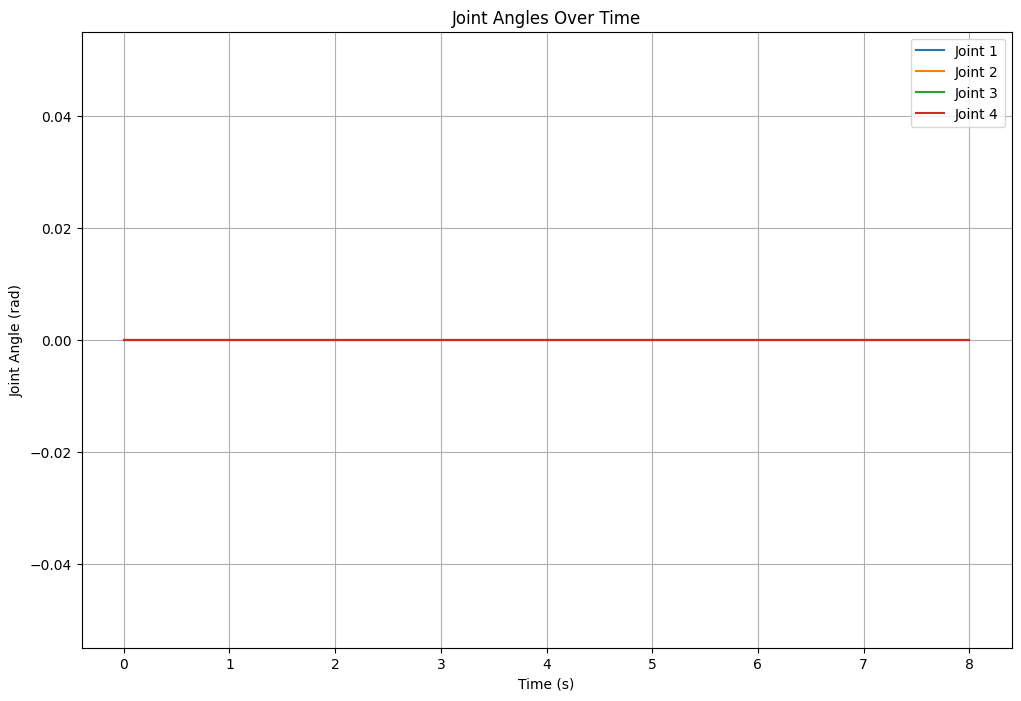

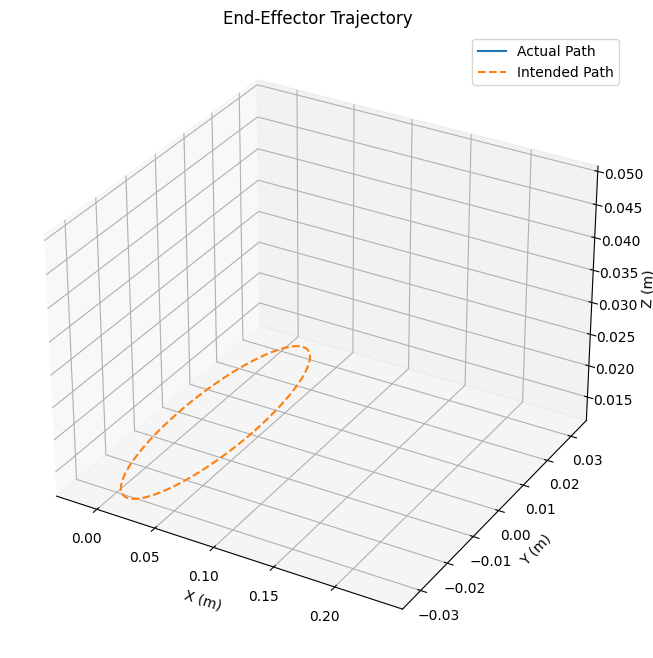

In [79]:
import numpy as np
import matplotlib.pyplot as plt


# Modify the IK selection to consider joint limits
def is_within_limits(q):
    return all(joint_limits[i][0] <= q[i] <= joint_limits[i][1] for i in range(4))

# Parameters
T = 8
num_samples = 1000  # Increased number of samples
dt = T / (num_samples - 1)
time = np.linspace(0, T, num_samples)

# Trajectory parameters
radius = 0.032  # meters
center_x = 0.015  # meters
center_y = 0.0    # meters
center_z = 0.012  # meters

# Initialize arrays
q_array = np.zeros((num_samples, 4))
dq_array = np.zeros((num_samples, 4))
ddq_array = np.zeros((num_samples, 4))
ee_positions = np.zeros((num_samples, 3))
intended_positions = np.zeros((num_samples, 3))

# Previous joint angles
q_prev = None

for i in range(num_samples):
    t = time[i]
    angle = 2 * np.pi * t / T
    x = center_x + radius * np.cos(angle)
    y = center_y + radius * np.sin(angle)
    z = center_z
    phi = 0  # Adjust as needed
    intended_positions[i, :] = [x, y, z]
    
    # Inverse kinematics to get all possible joint angles
    q_solutions = inv_kinematics_all_solutions(x, y, z, phi)
    
    if not q_solutions:
        print(f"Position unreachable at time {t:.2f}s")
        continue  # Skip this time step if no solutions
    
    # Filter solutions within joint limits
    valid_solutions = [q_sol for q_sol in q_solutions if is_within_limits(q_sol)]
    if not valid_solutions:
        print(f"No valid IK solutions at time {t:.2f}s")
        continue
    
    if q_prev is not None:
        # Select the solution closest to q_prev
        q = min(valid_solutions, key=lambda q_sol: np.linalg.norm(np.array(q_sol) - q_prev))
    else:
        q = valid_solutions[0]
    
    q_array[i, :] = q
    q_prev = np.array(q)

# Compute velocities and accelerations using central differences
dq_array[1:-1, :] = (q_array[2:, :] - q_array[:-2, :]) / (2 * dt)
dq_array[0, :] = (q_array[1, :] - q_array[0, :]) / dt
dq_array[-1, :] = (q_array[-1, :] - q_array[-2, :]) / dt

ddq_array[1:-1, :] = (dq_array[2:, :] - dq_array[:-2, :]) / (2 * dt)
ddq_array[0, :] = (dq_array[1, :] - dq_array[0, :]) / dt
ddq_array[-1, :] = (dq_array[-1, :] - dq_array[-2, :]) / dt

# Compute end-effector positions
for i in range(num_samples):
    q = q_array[i, :]
    T04 = forward_kinematics4(q[0], q[1], q[2], q[3])
    p4 = T04[:3, 3]
    ee_positions[i, :] = p4

# Compute differences
diff = ee_positions - intended_positions
print("Maximum position difference (meters):", np.max(np.abs(diff)))

# Plot joint angles
plt.figure(figsize=(12, 8))
for joint in range(4):
    plt.plot(time, q_array[:, joint], label=f'Joint {joint + 1}')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (rad)')
plt.title('Joint Angles Over Time')
plt.legend()
plt.grid(True)
plt.show()

# Plot end-effector trajectory
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(ee_positions[:, 0], ee_positions[:, 1], ee_positions[:, 2], label='Actual Path')
ax.plot(intended_positions[:, 0], intended_positions[:, 1], intended_positions[:, 2], label='Intended Path', linestyle='--')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('End-Effector Trajectory')
ax.legend()
ax.grid(True)

plt.show()


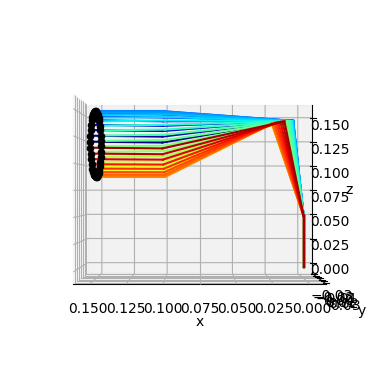

In [82]:
from matplotlib import colors
from matplotlib import cm

fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

norm = colors.Normalize(vmin=0, vmax=len(ps))

for i, p in enumerate(ps):
    target = (*p, 0)  # x, y, z, phi
    t1, t2, t3, t4 = inv_kinematics(*target)

    # Compute transformation matrices
    T_0_1 = forward_kinematics1(t1)
    T_0_2 = forward_kinematics2(t1, t2)
    T_0_3 = forward_kinematics3(t1, t2, t3)
    T_0_4 = forward_kinematics4(t1, t2, t3, t4)

    # Compute joint positions
    origin = np.array([0, 0, 0, 1])
    joint1_position = T_0_1 @ origin
    joint2_position = T_0_2 @ origin
    joint3_position = T_0_3 @ origin
    joint4_position = T_0_4 @ origin

    joints = np.array([
        origin[:3], joint1_position[:3], joint2_position[:3], joint3_position[:3], joint4_position[:3]
    ])

    # Plot links
    for a, b in zip(joints, joints[1:]):
        ax.plot([a[0], b[0]], [a[1], b[1]], zs=[a[2], b[2]], c=cm.jet(norm(i)))

    # Plot end-effector position
    ax.scatter(joints[-1, 0], joints[-1, 1], zs=joints[-1, 2], c='black')

ax.view_init(elev=0, azim=90, roll=0)
plt.show()


# Try again

In [89]:
# Link lengths in meters
a1 = 50 / 1000.0  # 0.05 m
a2 = 93 / 1000.0  # 0.093 m
a3 = 93 / 1000.0  # 0.093 m
a4 = 50 / 1000.0  # 0.05 m

# Masses in kg
m1 = 0.06
m2 = 0.08
m3 = 0.08
m4 = 0.04

# Estimated I0
I0 = 5.625e-6  # kg·m²

# Inertia matrices
D_bar_1 = np.diag([I0, 0.4 * I0, 0.9 * I0])
D_bar_2 = D_bar_3 = np.diag([0.45 * I0, 1.4 * I0, 1.2 * I0])
D_bar_4 = np.diag([0.5 * I0, 0.5 * I0, 0.5 * I0])


In [90]:
def compute_mass_matrix(q):
    # Extract joint angles
    q1, q2, q3, q4 = q

    # Simplify the mass matrix to a diagonal matrix
    # For demonstration, we consider only the main inertia contributions

    # Effective masses for each joint
    # This is a simplification; for accurate results, compute D(q) using Jacobians
    D = np.zeros((4, 4))

    # For simplicity, assume that each joint's inertia only depends on its own motion
    D[0, 0] = I0 + m2 * (a2**2 + a3**2 + 2 * a2 * a3 * np.cos(q2 + q3))
    D[1, 1] = I0 + m2 * a2**2
    D[2, 2] = I0 + m3 * a3**2
    D[3, 3] = I0 + m4 * a4**2

    return D


In [91]:
def compute_coriolis_matrix(q, dq):
    # For simplicity, assume C(q, dq) is negligible
    C = np.zeros((4, 4))
    return C


In [92]:
def compute_gravity_vector(q_vals):
    import sympy as sp
    # Gravitational acceleration
    g_const = 9.81  # m/s^2

    # Define symbolic variables
    q2_sym, q3_sym, q4_sym = sp.symbols('q2 q3 q4')

    # Extract numerical values
    q1_num, q2_num, q3_num, q4_num = q_vals

    # Compute the position of each link's center of mass symbolically
    z1 = a1  # Height of link 1 (constant)

    # Link 2
    z2 = a1 + (a2 / 2) * sp.sin(q2_sym)
    y2 = (a2 / 2) * sp.cos(q2_sym)

    # Link 3
    z3 = z2 + (a3 / 2) * sp.sin(q2_sym + q3_sym)
    y3 = y2 + (a3 / 2) * sp.cos(q2_sym + q3_sym)

    # Link 4
    z4 = z3 + (a4 / 2) * sp.sin(q2_sym + q3_sym + q4_sym)
    y4 = y3 + (a4 / 2) * sp.cos(q2_sym + q3_sym + q4_sym)

    # Potential energy of each link
    U1 = m1 * g_const * z1
    U2 = m2 * g_const * z2
    U3 = m3 * g_const * z3
    U4 = m4 * g_const * z4

    # Total potential energy
    U = U1 + U2 + U3 + U4

    # Compute gravity vector symbolically
    g_sym = sp.Matrix([0, 0, 0, 0])
    g_sym[0] = 0  # No gravity effect on q1 (rotation about vertical axis)
    g_sym[1] = sp.diff(U, q2_sym)
    g_sym[2] = sp.diff(U, q3_sym)
    g_sym[3] = sp.diff(U, q4_sym)

    # Substitute numerical values
    substitutions = {
        q2_sym: q2_num,
        q3_sym: q3_num,
        q4_sym: q4_num
    }

    g_num = np.array([float(g_i.evalf(subs=substitutions)) for g_i in g_sym])

    return g_num


In [93]:
import numpy as np

# Time parameters
T = 8
num_samples = 1000
dt = T / (num_samples - 1)
time = np.linspace(0, T, num_samples)

# Trajectory parameters
radius = 0.032  # meters
center_x = 0.015  # meters
center_y = 0.0    # meters
center_z = 0.012  # meters

# Initialize arrays
q_array = np.zeros((num_samples, 4))
dq_array = np.zeros((num_samples, 4))
ddq_array = np.zeros((num_samples, 4))

# Previous joint angles
q_prev = None

for i in range(num_samples):
    t = time[i]
    angle = 2 * np.pi * t / T
    x = center_x + radius * np.cos(angle)
    y = center_y + radius * np.sin(angle)
    z = center_z
    phi = 0  # Adjust as needed

    # Inverse kinematics to get joint angles
    q_solutions = inv_kinematics_all_solutions(x, y, z, phi)

    if not q_solutions:
        print(f"No valid IK solutions at time {t:.2f}s")
        continue

    if q_prev is not None:
        q = min(q_solutions, key=lambda q_sol: np.linalg.norm(np.array(q_sol) - q_prev))
    else:
        q = q_solutions[1]

    q_array[i, :] = q
    q_prev = np.array(q)

# Compute velocities and accelerations using central differences
dq_array[1:-1, :] = (q_array[2:, :] - q_array[:-2, :]) / (2 * dt)
dq_array[0, :] = (q_array[1, :] - q_array[0, :]) / dt
dq_array[-1, :] = (q_array[-1, :] - q_array[-2, :]) / dt

ddq_array[1:-1, :] = (dq_array[2:, :] - dq_array[:-2, :]) / (2 * dt)
ddq_array[0, :] = (dq_array[1, :] - dq_array[0, :]) / dt
ddq_array[-1, :] = (dq_array[-1, :] - dq_array[-2, :]) / dt

# Initialize torque array
tau_array = np.zeros((num_samples, 4))

for i in range(num_samples):
    q_vals = q_array[i, :]
    dq_vals = dq_array[i, :]
    ddq_vals = ddq_array[i, :]

    # Compute D, C, g numerically
    D_num = compute_mass_matrix(q_vals)
    C_num = compute_coriolis_matrix(q_vals, dq_vals)
    g_num = compute_gravity_vector(q_vals)

    # Compute torque
    tau = D_num @ ddq_vals + C_num @ dq_vals + g_num
    tau_array[i, :] = tau


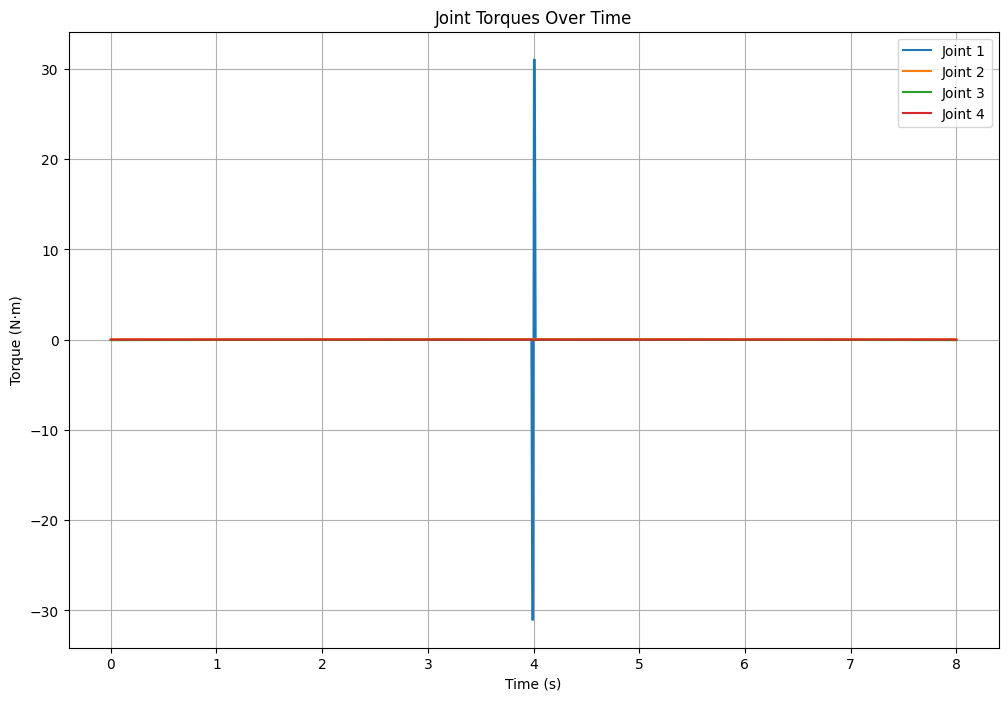

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for joint in range(4):
    plt.plot(time, tau_array[:, joint], label=f'Joint {joint + 1}')
plt.xlabel('Time (s)')
plt.ylabel('Torque (N·m)')
plt.title('Joint Torques Over Time')
plt.legend()
plt.grid(True)
plt.show()
